In [1]:
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
from tabulate import tabulate
from matplotlib import cm
from datetime import datetime

Latency C0→C3 = 0.886 ms


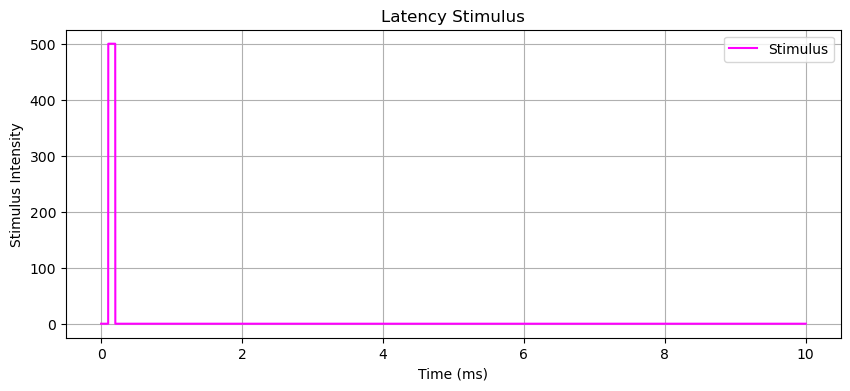

Plotting graph...


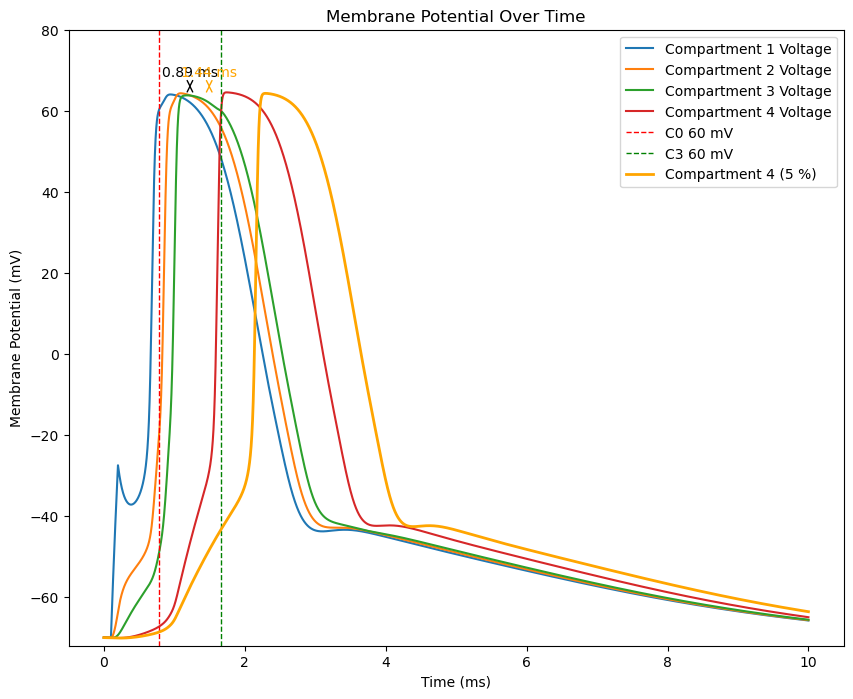

Total run time: 0:00:08.265887


In [2]:
def stim_100hz(dt_100hz=0.001, tf_100hz=100, amplitude_100hz=1):
    t_100hz = np.arange(0, tf_100hz, dt_100hz)
    freq_100hz = 100  ### Frequency in Hz
    period_100hz = 1 / freq_100hz * 1000  ### Period in ms
    pulse_width_100hz = 0.03  ### Pulse width in ms
    I_100hz = np.zeros_like(t_100hz)

    for start_100hz in np.arange(0, tf_100hz, period_100hz):
        end_100hz = start_100hz + pulse_width_100hz
        I_100hz[(t_100hz >= start_100hz) & (t_100hz < end_100hz)] = amplitude_100hz
        
    intervals = int(tf_100hz / period_100hz)
    
    return t_100hz, I_100hz, intervals




def stim_latency(dt_latency=1, tf_latency=10, amplitude_latency=1):
    t_latency = np.arange(0, tf_latency, dt_latency)
    freq_latency = 0.1 ### Frequency in Hz
    period_latency = 1 / freq_latency * 10 ### Period in ms
    pulse_width_latency = 0.1 ### Pulse width in ms
    I_latency = np.zeros_like(t_latency)

    for start_latency in np.arange(0.1, tf_latency, period_latency):
        end_latency = start_latency + pulse_width_latency
        I_latency[(t_latency >= start_latency) & (t_latency < end_latency)] = amplitude_latency
    return t_latency, I_latency


def sigmoidal_ggap(sigmoid_percentage_values, max_L=135, k=0.129, x0=41, min_L=34.5):
    if sigmoid_percentage_values < 10.2:
        ggap_base = min_L + (max_L - min_L) / (1 + np.exp(-k * (sigmoid_percentage_values - x0)))
    else:
        ggap_base = max_L
    return ggap_base

def ninf(V): return 1./(1 + np.exp((-53. - V) / 15.))
def minf_nat(V): return 1/(1+np.exp((V-v1_2m)/km))
def hinf_nat(V): return 1/(1+np.exp((V-v1_2h)/kh))

v1_2m, km = -29.13, -8.92
v1_2h, kh = -47, 5

def initialize_neuron(compartments, initial_v, N, stimulus_mode, ninf, minf_nat, hinf_nat, first_interval=True):

    v = np.zeros((compartments, N))
    n = np.zeros((compartments, N))
    m = np.zeros((compartments, N))
    h = np.zeros((compartments, N))
    s = np.zeros(N)

    if stimulus_mode == '100hz':
        initial_v_to_use = -68 if first_interval else -70
        for comp in range(compartments):
            v[comp, 0] = initial_v_to_use
            n[comp, 0] = ninf(initial_v_to_use)  
            m[comp, 0] = minf_nat(initial_v_to_use)
            h[comp, 0] = hinf_nat(initial_v_to_use)
    else:
        for comp in range(compartments):
            v[comp, 0] = initial_v
            n[comp, 0] = ninf(initial_v) 
            m[comp, 0] = minf_nat(initial_v)
            h[comp, 0] = hinf_nat(initial_v)

    return v, n, m, h, s





def get_stimulus(t, dt, mode, amplitude):
    if mode == 'latency':
        t_latency, I_latency = stim_latency(tf_latency=t, dt_latency=dt, amplitude_latency=amplitude)
        return t_latency, I_latency, None
    elif mode == '100hz':
        t_100hz, I_100hz, intervals = stim_100hz(tf_100hz=t, dt_100hz=dt, amplitude_100hz=amplitude)
        return t_100hz, I_100hz, intervals
    else:
        raise ValueError("Invalid stimulus mode selected. Choose either 'latency' or '100hz'.")




def myneuron(gL, gk, gna, gel, gsyn, model_percentage_filled, noise_level, seed,
             max_L, k, x0, min_L, taud, taur, Vsyn, stimulus_mode, amplitude=1, ):
    if stimulus_mode == 'latency':
        dt = 0.0001  ### Time step for latency (ms)
        t = 10  ### Total time for latency (ms)
    elif stimulus_mode == '100hz':
        dt = 0.001  ### Time step for 100hz (ms)
        t = 100  ### Total time for 100hz (ms)
    else:
        raise ValueError("Invalid stimulus mode selected. Choose either 'latency' or '100hz'.")

    N = round(t/dt)

    if seed is None:
        seed = np.random.randint(0, 10000)
    np.random.seed(seed)
    
    def ninf(V): return 1./(1 + np.exp((-53. - V) / 15.)*1)
            
    def taun(V): return taun_multiplier * (1.1 + 4.7 * np.exp(-((-79. - V) / 50.)**2))
    def minf(V): return 1./(1 + np.exp((-40. - V) / 15.))
    def taum(V): return 0.04 + 0.46 * np.exp(-((-38. - V) / 30.)**2)
    def hinf(V): return 1./(1. + np.exp((-62. - V) / -7.))
    def tauh(V): return 1.2 + 7.4 * np.exp(-((-67. - V) / 20.)**2)
    v1_2m, km = -29.13, -8.92
    v1_2h, kh = -47, 5
    def minf_nat(V): return 1/(1+np.exp((V-v1_2m)/km))
    def mtau_nat(V): return 0.13 + 3.43/(1+np.exp((V+45.35)/5.98))
    def hinf_nat(V): return 1/(1+np.exp((V-v1_2h)/kh))
    def htau_nat(V): return 0.36 + np.exp((V+20.65)/-10.47)
    
    El = -85  ### Leak reversal potential (mV)
    Ek = -74  ### Potassium reversal potential (mV)
    Ena = 65  ### Sodium reversal potential (mV)
#     EChR2 = 0 ### Channelrhodopsin-2 reversal potential (mV)
    v, n, m, h, s = initialize_neuron(4, -70 if stimulus_mode == 'latency' else -68, N, 
                                      stimulus_mode, ninf, minf_nat, hinf_nat)

    ggap_values = np.zeros(N)
    
    ### Generate the stimulus
    time, stimulus, intervals = get_stimulus(t=t, dt=dt, mode=stimulus_mode, amplitude=amplitude)

    for i in range(N-1):
        ggap_base_unfinished = sigmoidal_ggap(model_percentage_filled,max_L, k, x0, min_L)  # Gap junction conductance (μS)
        ggap_base = ggap_base_unfinished / (1 + np.exp(-k * (model_percentage_filled - x0)))
        
        ggap_random_factor = np.random.uniform(1 - noise_level, 1 + noise_level)
        ggap = ggap_base * ggap_random_factor
        
        ggap_values[i] = ggap
        
        taun_multiplier = 1
        taur = 0.1  
        taud = 3
        gsyn = 0.08 
        Vsyn= 0
        Istim = stimulus[i]
        
        v[0, i+1] = v[0, i] + dt*(-gna*h[0, i]*(m[0, i]**3)*(v[0, i]-Ena) - gk*(n[0, i]**4)*(v[0, i]-Ek) - gL*(v[0, i]-El) + Istim - gel*(v[0, i]-v[1, i]))
        n[0, i+1] = n[0, i] + dt*((ninf(v[0, i]) - n[0, i])/taun(v[0, i]))
        m[0, i+1] = m[0, i] + dt*((minf_nat(v[0, i]) - m[0, i])/mtau_nat(v[0, i]))
        h[0, i+1] = h[0, i] + dt*((hinf_nat(v[0, i]) - h[0, i])/htau_nat(v[0, i]))
        
        v[1, i+1] = v[1, i] + dt*(-gna*h[1, i]*(m[1, i]**3)*(v[1, i]-Ena) - gk*(n[1, i]**4)*(v[1, i]-Ek) - gL*(v[1, i]-El) - gel*(v[1, i]-v[0, i]) - gel*(v[1, i]-v[2, i]))
        n[1, i+1] = n[1, i] + dt*((ninf(v[1, i]) - n[1, i])/taun(v[1, i]))
        m[1, i+1] = m[1, i] + dt*((minf_nat(v[1, i]) - m[1, i])/mtau_nat(v[1, i]))
        h[1, i+1] = h[1, i] + dt*((hinf_nat(v[1, i]) - h[1, i])/htau_nat(v[1, i]))
        
        v[2, i+1] = v[2, i] + dt*(-gna*h[2, i]*(m[2, i]**3)*(v[2, i]-Ena) - gk*(n[2, i]**4)*(v[2, i]-Ek) - gL*(v[2, i]-El) - gel*(v[2, i]-v[1, i]) - ggap*(v[2, i]-v[3, i]))
        n[2, i+1] = n[2, i] + dt*((ninf(v[2, i]) - n[2, i])/taun(v[2, i]))
        m[2, i+1] = m[2, i] + dt*((minf_nat(v[2, i]) - m[2, i])/mtau_nat(v[2, i]))
        h[2, i+1] = h[2, i] + dt*((hinf_nat(v[2, i]) - h[2, i])/htau_nat(v[2, i]))
        
        s[i+1] = s[i] + dt * ((1 + np.tanh(v[2,i]/4))/2 * (1-s[i])/taur - s[i]/taud)
        Isyn = gsyn*s[i]*(Vsyn - v[3,i])
        Isyn_values = np.zeros(N)
        Isyn_values[i] = Isyn  
        
        v[3, i+1] = v[3, i] + dt*(-gna*h[3, i]*(m[3, i]**3)*(v[3, i]-Ena) - gk*(n[3, i]**4)*(v[3, i]-Ek) - gL*(v[3, i]-El) - ggap*(v[3, i]-v[2 ,i]) - Isyn)
        n[3, i+1] = n[3, i] + dt*((ninf(v[3, i]) - n[3, i])/taun(v[3, i]))
        m[3, i+1] = m[3, i] + dt*((minf_nat(v[3, i]) - m[3, i])/mtau_nat(v[3, i]))
        h[3, i+1] = h[3, i] + dt*((hinf_nat(v[3, i]) - h[3, i])/htau_nat(v[3, i]))

    return time, stimulus, v, n, m, h, s, seed



def find_highest_peaks_in_intervals(v, time, intervals, threshold=30):
    peaks_dict = {i: [] for i in range(v.shape[0])}  
    interval_length = len(time) // intervals  
    
    for comp in range(v.shape[0]):  
        for interval_index in range(intervals):  
            start_idx = interval_index * interval_length
            end_idx = start_idx + interval_length

            v_interval = v[comp, start_idx:end_idx]
            time_interval = time[start_idx:end_idx]

            peak_indices, properties = find_peaks(v_interval, height=threshold)

            if peak_indices.size > 0:                  
                max_peak_idx = peak_indices[np.argmax(properties['peak_heights'])]
                peak_idx = start_idx + max_peak_idx  
                peak_voltage = v_interval[max_peak_idx]
                peaks_dict[comp].append((interval_index, peak_idx, peak_voltage))
            else:
                peaks_dict[comp].append((interval_index, None, None))

    return peaks_dict


def calculate_time_delays(peaks_dict, intervals, dt):    
    delay_dict = {interval: [] for interval in range(intervals)}  
    
    for interval in range(intervals):
        peak_indices = []
        for comp in peaks_dict:
            interval_peaks = [peak for peak in peaks_dict[comp] if peak[0] == interval]
            if interval_peaks and interval_peaks[0][1] is not None:
                peak_indices.append(interval_peaks[0][1])
            else:
                peak_indices.append(None)  
        for i in range(len(peak_indices) - 1):
            if peak_indices[i] is not None and peak_indices[i+1] is not None:
                delay = (peak_indices[i+1] - peak_indices[i]) * dt  
                delay_dict[interval].append(delay)
            else:
                delay_dict[interval].append(None)  
    
    return delay_dict



def pad_list_to_length(lst, length, pad_value=None):
    return lst + [pad_value] * (length - len(lst))




def first_crossing_idx(trace, thresh):
    """
    Index of the first sample where `trace` crosses `thresh` upward.
    Returns None if it never crosses.
    """
    above = trace >= thresh
    if not above.any():
        return None
    return np.argmax(above)

def latency_ms(time, v, pre_comp=0, post_comp=3, thresh=60):
    """
    Latency (ms) between first threshold crossing of `pre_comp`
    and `post_comp`.  Returns (latency, idx_pre, idx_post).
    """
    idx_pre  = first_crossing_idx(v[pre_comp],  thresh)
    idx_post = first_crossing_idx(v[post_comp], thresh)
    if idx_pre is None or idx_post is None:
        return None, idx_pre, idx_post
    return (time[idx_post] - time[idx_pre]), idx_pre, idx_post



### Parameters
amplitude = 500
gL, gk, gna, gel, gsyn = 0.03, 10, 300, 3.6, 0.08  ### Conductances in μS
model_percentage_filled_values = [10]  ### Gap Junction % 
noise_level = 0
seed = None  ### Use None for a random seed
max_L, k, x0, min_L = 135, 0.129, 41, 34.5  
taud, taur, Vsyn = 3, 0.08, 0
stimulus_mode = 'latency'  ### Choose 'latency' or '100hz'
trials = 1  ### Number of trials
runs_per_trial = 1  ### Number of runs per trial


if stimulus_mode == 'latency':
    dt = 0.0001  
    t = 10
elif stimulus_mode == '100hz':
    dt = 0.001
    t = 100
    
N = round(t/dt)    

start_time = datetime.now()
### Run the model
results_df = pd.DataFrame()

if stimulus_mode == '100hz':
    for trial in range(trials):
        trial_seed = seed + trial if seed is not None else np.random.randint(0, 10000)
        np.random.seed(trial_seed)
        run_seed = trial_seed
        for run in range(runs_per_trial):
            np.random.seed(run_seed)
            first_interval = (run == 0)
            
            v, n, m, h, s = initialize_neuron(4, -70, N, stimulus_mode, ninf, minf_nat, hinf_nat, first_interval)
            for model_percentage_filled in model_percentage_filled_values:
                time, stimulus, v, n, m, h, s, used_seed = myneuron(gL=gL, gk=gk, gna=gna, gel=gel, gsyn=gsyn, 
                                                                    model_percentage_filled=model_percentage_filled,
                                                                    noise_level=noise_level, seed=run_seed, 
                                                                    max_L=max_L, k=k, x0=x0, min_L=min_L, 
                                                                    taud=taud, taur=taur, Vsyn=Vsyn,
                                                                    stimulus_mode=stimulus_mode, amplitude=amplitude) 
          
                run_seed += 1
                
                _, _, intervals = get_stimulus(t=len(time) * 0.001, dt=0.001, mode=stimulus_mode, amplitude=amplitude)

                
                peaks_dict = find_highest_peaks_in_intervals(v, time, intervals, threshold=30)
                delay_dict = calculate_time_delays(peaks_dict, intervals, dt)
                comp4_delays = [delay_dict[interval][-1] for interval in range(intervals)]

                
                interval_data = []
                for interval in range(intervals):
                    peak_voltage = peaks_dict[3][interval][2]
                    peak_detected = peak_voltage is not None
                    delay = comp4_delays[interval]

                    interval_data.append({
                        'interval': interval,
                        'model_percentage_filled': model_percentage_filled,
                        'compartment_4_peak_detected': peak_detected,
                        'compartment_4_peak_voltage': peak_voltage,
                        'comp1_to_comp4_delay': delay
                    })

                
                interval_df = pd.DataFrame(interval_data)
                results_df = pd.concat([results_df, interval_df], ignore_index=True)

    ### Stiumulus current plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, stimulus, color='magenta', label='Stimulus')
    plt.title(f'{stimulus_mode.capitalize()} Stimulus')
    plt.xlabel('Time (ms)')
    plt.ylabel('Stimulus Intensity')
    plt.grid(True)
    plt.legend()
    plt.show()

    ### 100hz plot
    print("Plotting graph...")
    plt.figure(figsize=(10, 8))
    plt.plot(time, v[0, :], label='Compartment 1 Voltage')
#     plt.plot(time, v[1, :], label='Compartment 2 Voltage')
#     plt.plot(time, v[2, :], label='Compartment 3 Voltage')
    plt.plot(time, v[3, :], label='Compartment 4 Voltage')
    for x in np.arange(0, max(time)+1, 10):  # Adjust the range to match stimulus onsets
        plt.axvline(x, color='red', linestyle='--', linewidth=0.5, label='Stimulus Onset' if x == 0 else None)
    plt.title(f'Membrane Potential Over Time at {model_percentage_filled}%')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.legend(loc="upper right")
    plt.show()

    ### Response curve plot
    results_df['model_percentage_filled'] = results_df['model_percentage_filled'].apply(lambda x: f"{x}%")
    results_df['compartment_4_peak_detected'] = results_df['compartment_4_peak_detected'].astype(int)
    percentage_values = results_df['model_percentage_filled'].unique()
    intervals = results_df['interval'].max()
    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(percentage_values)))
    for i, percentage in enumerate(percentage_values):
        filtered_data = results_df[results_df['model_percentage_filled'] == percentage]
        interval_means = filtered_data.groupby('interval')['compartment_4_peak_detected'].sum()
        plt.plot(interval_means.index, interval_means.values, marker='o', linestyle='-', color=colors[i], label=f'{percentage} Filled')
    plt.xlabel('Interval Number')
    plt.ylabel('Firing Probability (%)')
    plt.title('Average Firing Probability per Interval Across Runs n=' +str(runs_per_trial)+' runs')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.xticks(range(1, intervals + 1))
    plt.show()
    
    end_time = datetime.now()
    duration = end_time - start_time
    print(f"Total run time: {duration}")
    print("Simulation results:")
    pd.set_option('display.max_rows', 1*runs_per_trial*trials)  
    print(results_df)
    
    
else:
    for model_percentage_filled in model_percentage_filled_values:
        results = myneuron(gL, gk, gna, gel, gsyn, model_percentage_filled, noise_level, seed,
                           max_L, k, x0, min_L, taud, taur, Vsyn, 
                           stimulus_mode=stimulus_mode, amplitude=amplitude)

        time, stimulus, v, n, m, h, s, used_seed = results
        data = {
            'model_percentage_filled': model_percentage_filled,
            'time': time,
            'stimulus': stimulus,
            'compartment_1_voltage': v[0, :],
            'compartment_2_voltage': v[1, :],
            'compartment_3_voltage': v[2, :],
            'compartment_4_voltage': v[3, :],
            'seed': used_seed
        }

        latency, idx0, idx3 = latency_ms(time, v, pre_comp=0, post_comp=3, thresh=60)
        print(f"Latency C0→C3 = {latency:.3f} ms" if latency is not None
              else "C0 or C3 never crossed threshold.")

        run_df = pd.DataFrame(data)
        results_df = pd.concat([results_df, run_df], ignore_index=True)

    ### Plotting the stimulus
    plt.figure(figsize=(10, 4))
    plt.plot(time, stimulus, color='magenta', label='Stimulus')
    plt.title(f'{stimulus_mode.capitalize()} Stimulus')
    plt.xlabel('Time (ms)')
    plt.ylabel('Stimulus Intensity')
    plt.grid(True)
    plt.legend()
    plt.show()

    ### Plotting the results
    print("Plotting graph...")
    plt.figure(figsize=(10, 8))
    plt.plot(time, v[0, :], label='Compartment 1 Voltage')
    plt.plot(time, v[1, :], label='Compartment 2 Voltage')
    plt.plot(time, v[2, :], label='Compartment 3 Voltage')
    plt.plot(time, v[3, :], label='Compartment 4 Voltage')


    if idx0 is not None:
        plt.axvline(time[idx0], color='red',  linestyle='--', linewidth=1,
                    label='C0 60 mV')
    if idx3 is not None:
        plt.axvline(time[idx3], color='green', linestyle='--', linewidth=1,
                    label='C3 60 mV')
    

    if idx0 is not None and idx3 is not None:
        mid_t = (time[idx0] + time[idx3]) / 2
        ymax  = max(v[0, idx0], v[3, idx3]) + 5   
        plt.annotate(f'{latency:.2f} ms',
                     xy=(mid_t, ymax),
                     xytext=(0, 8), textcoords='offset points',
                     ha='center', va='bottom',
                     arrowprops={'arrowstyle':'<->'})
    plt.ylim(-72, 85) 



    time2, stim2, v2, *_ = myneuron(
            gL=gL, gk=gk, gna=gna, gel=gel, gsyn=gsyn,
            model_percentage_filled=5,          
            noise_level=noise_level, seed=seed,
            max_L=max_L, k=k, x0=x0, min_L=min_L,
            taud=taud, taur=taur, Vsyn=Vsyn,
            stimulus_mode='latency', amplitude=amplitude)
    
    plt.plot(time2, v2[3, :],
             color='orange', linewidth=2,
             label='Compartment 4 (5 %)')

    lat2, _, idx3_2 = latency_ms(time2, v2, pre_comp=0, post_comp=3, thresh=60)
    if idx3_2 is not None and first_crossing_idx(v2[0], 60) is not None:
        idx0_2 = first_crossing_idx(v2[0], 60)
        mid_t2 = (time2[idx0_2] + time2[idx3_2]) / 2
        ymax2 = max(v2[0, idx0_2], v2[3, idx3_2]) + 5
        plt.annotate(f'{lat2:.2f} ms',
                     xy=(mid_t2, ymax2),
                     xytext=(0, 8), textcoords='offset points',
                     ha='center', va='bottom',
                     color='orange',
                     arrowprops={'arrowstyle': '<->', 'color': 'orange'})

    plt.ylim(-72, 80)
    # -------------------------------------------------------------------
    plt.title('Membrane Potential Over Time')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.legend(loc="upper right")
    plt.savefig("latency.pdf", bbox_inches="tight")   # ← save first
    plt.show()                                     
    end_time = datetime.now()
    duration = end_time - start_time
    print(f"Total run time: {duration}")

Plotting graph...


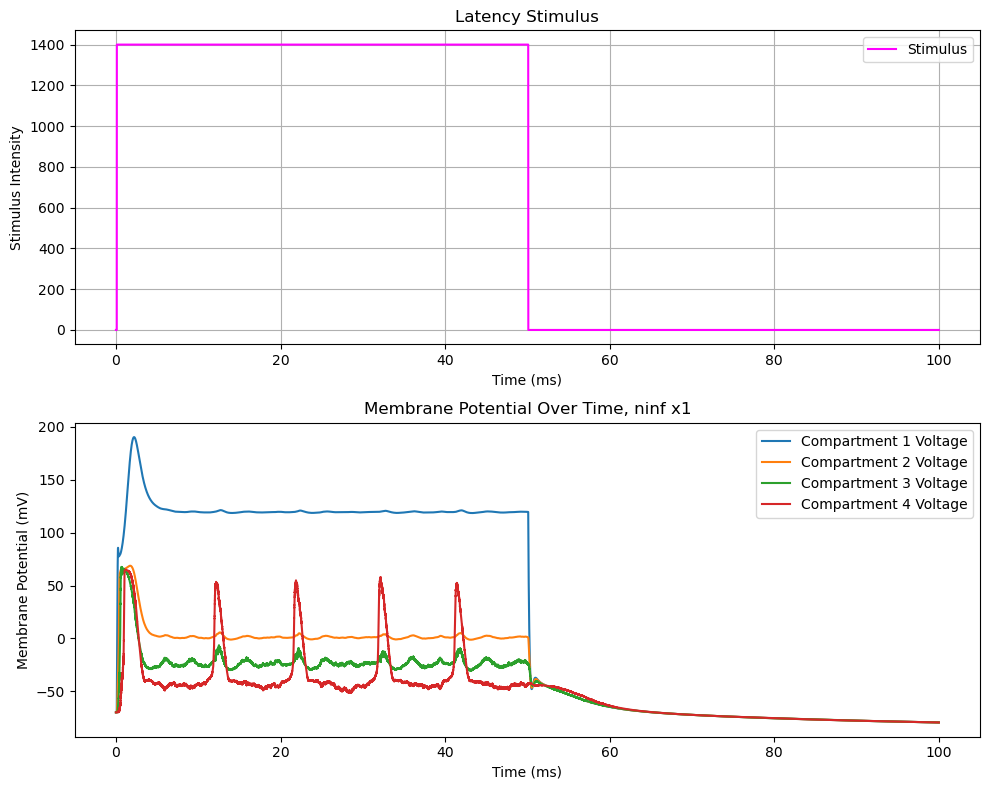

Total run time: 0:02:34.236740


In [9]:
### Plotting the results



print("Plotting graph...")

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(time, stimulus, color='magenta', label='Stimulus')
ax[0].set_title(f'{stimulus_mode.capitalize()} Stimulus')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Stimulus Intensity')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(time, v[0, :], label='Compartment 1 Voltage')
ax[1].plot(time, v[1, :], label='Compartment 2 Voltage')
ax[1].plot(time, v[2, :], label='Compartment 3 Voltage')
ax[1].plot(time, v[3, :], label='Compartment 4 Voltage')
ax[1].set_title('Membrane Potential Over Time, ninf x1')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Membrane Potential (mV)')
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

end_time = datetime.now()
duration = end_time - start_time
print(f"Total run time: {duration}")

Plotting graph...


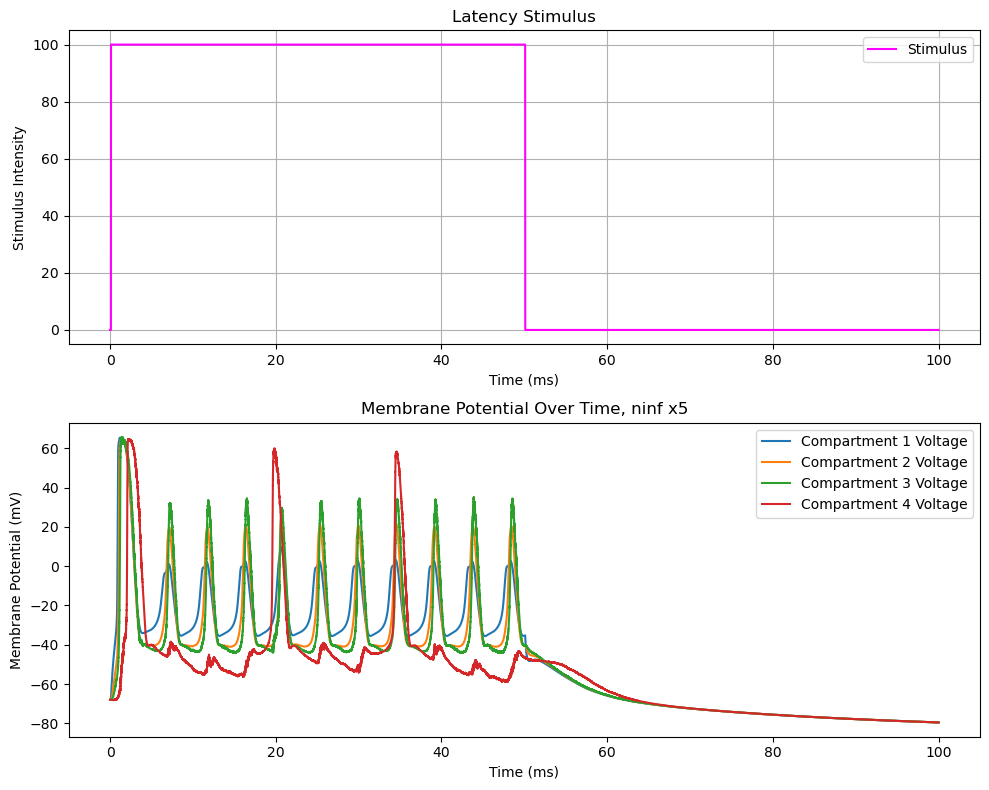

Total run time: 0:01:22.790868


In [131]:
### Plotting the results



print("Plotting graph...")

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(time, stimulus, color='magenta', label='Stimulus')
ax[0].set_title(f'{stimulus_mode.capitalize()} Stimulus')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Stimulus Intensity')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(time, v[0, :], label='Compartment 1 Voltage')
ax[1].plot(time, v[1, :], label='Compartment 2 Voltage')
ax[1].plot(time, v[2, :], label='Compartment 3 Voltage')
ax[1].plot(time, v[3, :], label='Compartment 4 Voltage')
ax[1].set_title('Membrane Potential Over Time, ninf x5')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Membrane Potential (mV)')
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

end_time = datetime.now()
duration = end_time - start_time
print(f"Total run time: {duration}")

Plotting graph...


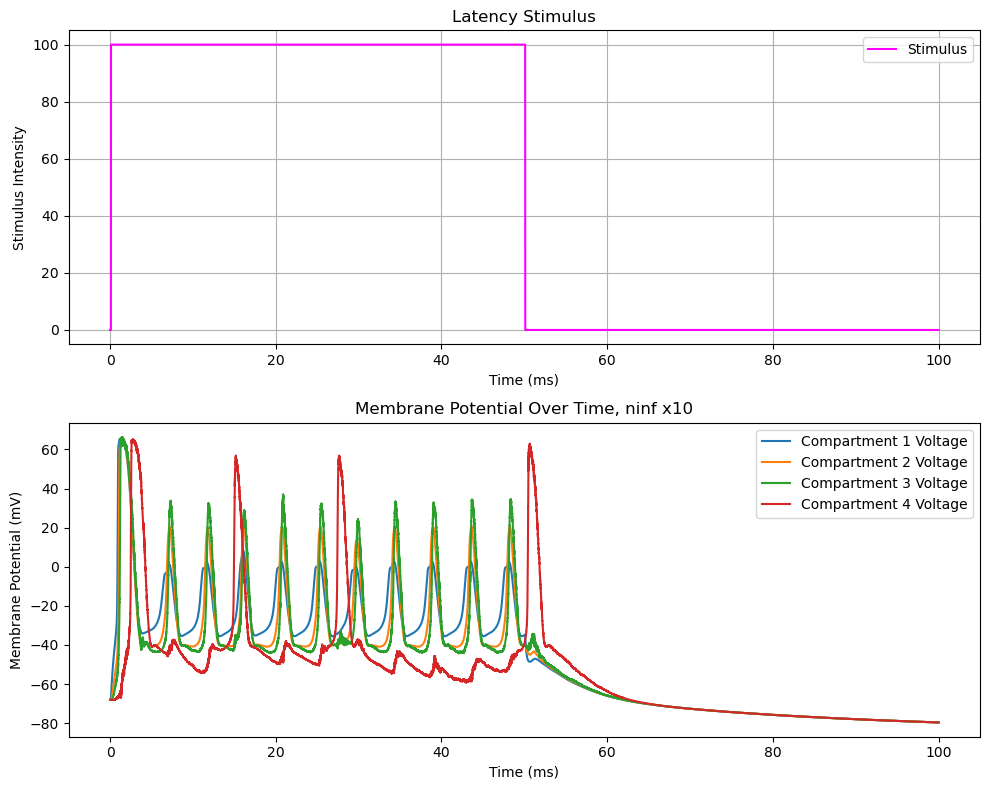

Total run time: 0:01:33.710759


In [133]:
### Plotting the results



print("Plotting graph...")
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(time, stimulus, color='magenta', label='Stimulus')
ax[0].set_title(f'{stimulus_mode.capitalize()} Stimulus')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Stimulus Intensity')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(time, v[0, :], label='Compartment 1 Voltage')
ax[1].plot(time, v[1, :], label='Compartment 2 Voltage')
ax[1].plot(time, v[2, :], label='Compartment 3 Voltage')
ax[1].plot(time, v[3, :], label='Compartment 4 Voltage')
ax[1].set_title('Membrane Potential Over Time, ninf x10')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Membrane Potential (mV)')
ax[1].legend(loc="upper right")


plt.tight_layout()
plt.show()

end_time = datetime.now()
duration = end_time - start_time
print(f"Total run time: {duration}")

In [ ]:
### Plotting the results



print("Plotting graph...")


fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(time, stimulus, color='magenta', label='Stimulus')
ax[0].set_title(f'{stimulus_mode.capitalize()} Stimulus')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Stimulus Intensity')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(time, v[0, :], label='Compartment 1 Voltage')
ax[1].plot(time, v[1, :], label='Compartment 2 Voltage')
ax[1].plot(time, v[2, :], label='Compartment 3 Voltage')
ax[1].plot(time, v[3, :], label='Compartment 4 Voltage')
ax[1].set_title('Membrane Potential Over Time, ninf x20')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Membrane Potential (mV)')
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

end_time = datetime.now()
duration = end_time - start_time
print(f"Total run time: {duration}")

Plotting graph...


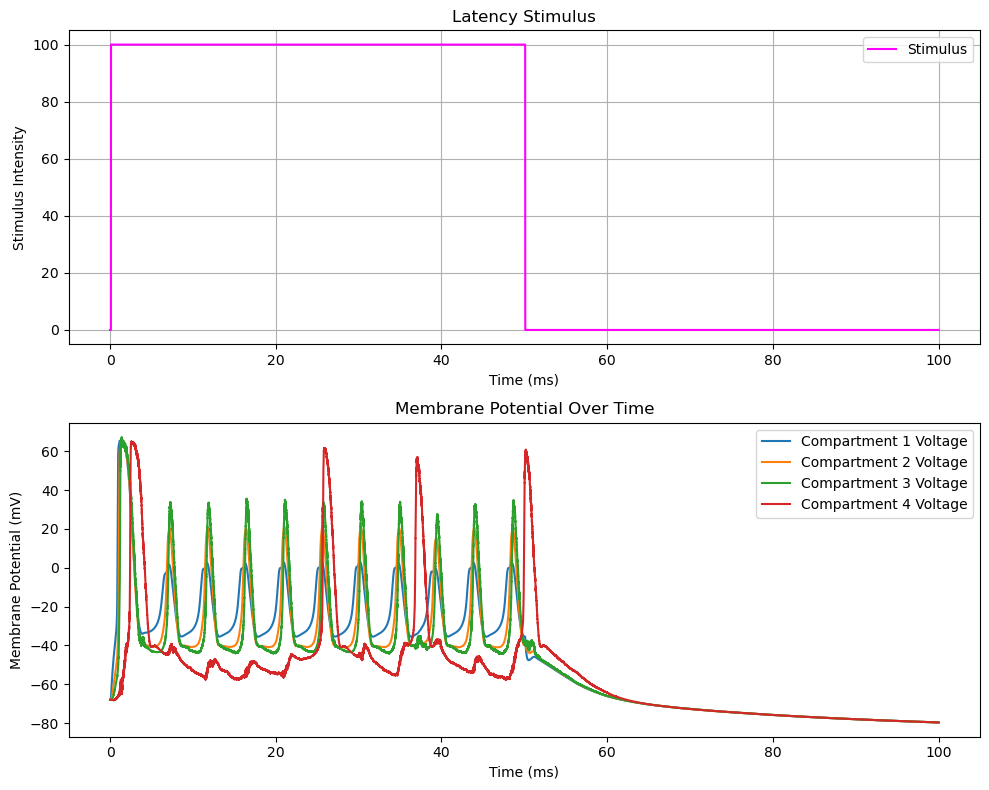

Total run time: 0:01:50.616629


In [106]:
### Plotting the results



print("Plotting graph...")


fig, ax = plt.subplots(2, 1, figsize=(10, 8))


ax[0].plot(time, stimulus, color='magenta', label='Stimulus')
ax[0].set_title(f'{stimulus_mode.capitalize()} Stimulus')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Stimulus Intensity')
ax[0].grid(True)
ax[0].legend()


ax[1].plot(time, v[0, :], label='Compartment 1 Voltage')
ax[1].plot(time, v[1, :], label='Compartment 2 Voltage')
ax[1].plot(time, v[2, :], label='Compartment 3 Voltage')
ax[1].plot(time, v[3, :], label='Compartment 4 Voltage')
ax[1].set_title('Membrane Potential Over Time')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Membrane Potential (mV)')
ax[1].legend(loc="upper right")


plt.tight_layout()
plt.show()

end_time = datetime.now()
duration = end_time - start_time
print(f"Total run time: {duration}")

Plotting graph...


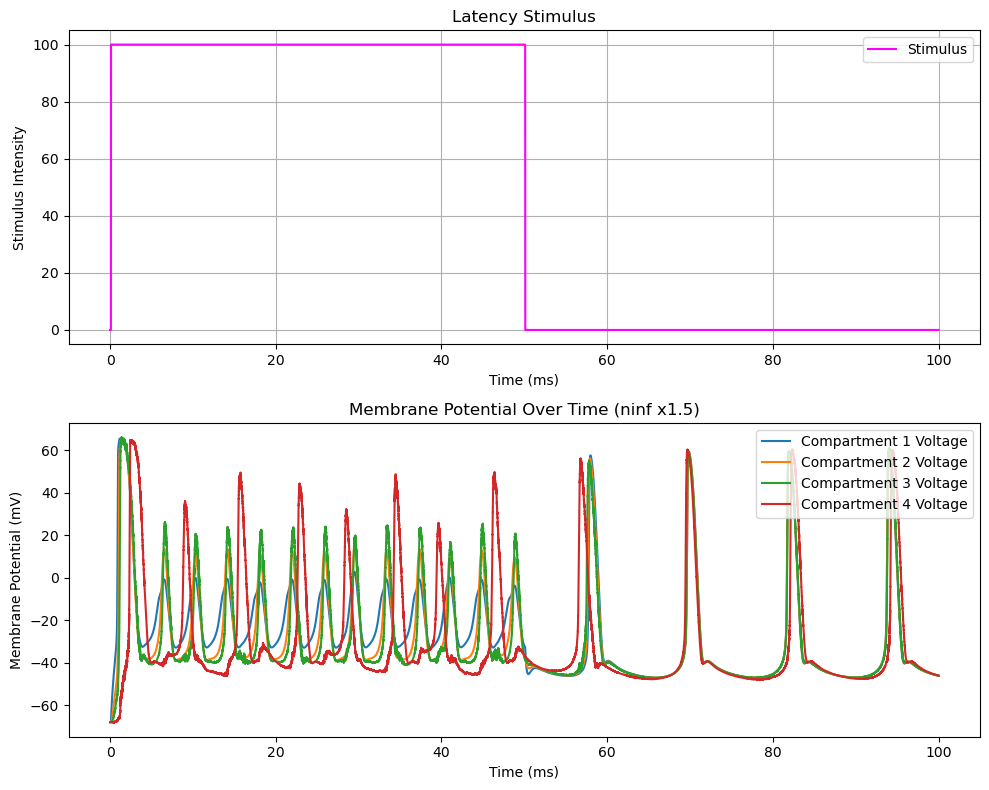

Total run time: 0:02:09.342923


In [116]:
### Plotting the results



print("Plotting graph...")


fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(time, stimulus, color='magenta', label='Stimulus')
ax[0].set_title(f'{stimulus_mode.capitalize()} Stimulus')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Stimulus Intensity')
ax[0].grid(True)
ax[0].legend()


ax[1].plot(time, v[0, :], label='Compartment 1 Voltage')
ax[1].plot(time, v[1, :], label='Compartment 2 Voltage')
ax[1].plot(time, v[2, :], label='Compartment 3 Voltage')
ax[1].plot(time, v[3, :], label='Compartment 4 Voltage')
ax[1].set_title('Membrane Potential Over Time (ninf x1.5)')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Membrane Potential (mV)')
ax[1].legend(loc="upper right")


plt.tight_layout()
plt.show()

end_time = datetime.now()
duration = end_time - start_time
print(f"Total run time: {duration}")

Plotting graph...


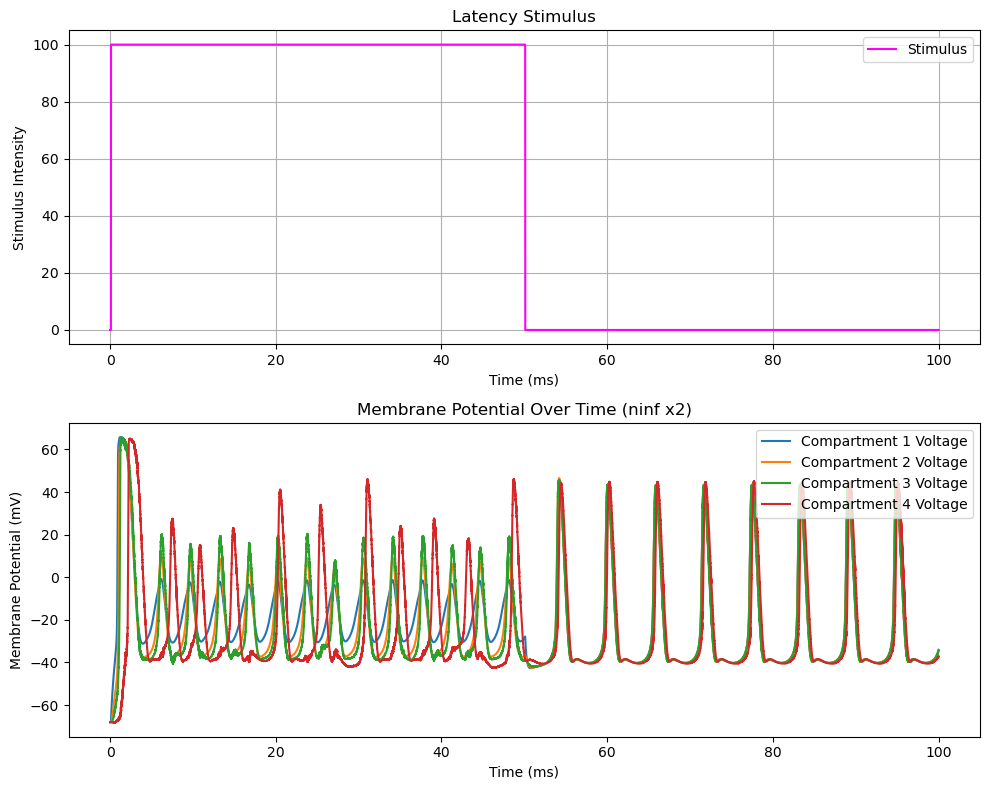

Total run time: 0:01:24.454084


In [114]:
### Plotting the results



print("Plotting graph...")
fig, ax = plt.subplots(2, 1, figsize=(10, 8))


ax[0].plot(time, stimulus, color='magenta', label='Stimulus')
ax[0].set_title(f'{stimulus_mode.capitalize()} Stimulus')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Stimulus Intensity')
ax[0].grid(True)
ax[0].legend()


ax[1].plot(time, v[0, :], label='Compartment 1 Voltage')
ax[1].plot(time, v[1, :], label='Compartment 2 Voltage')
ax[1].plot(time, v[2, :], label='Compartment 3 Voltage')
ax[1].plot(time, v[3, :], label='Compartment 4 Voltage')
ax[1].set_title('Membrane Potential Over Time (ninf x2)')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Membrane Potential (mV)')
ax[1].legend(loc="upper right")
plt.tight_layout()
plt.show()

end_time = datetime.now()
duration = end_time - start_time
print(f"Total run time: {duration}")

Plotting graph...


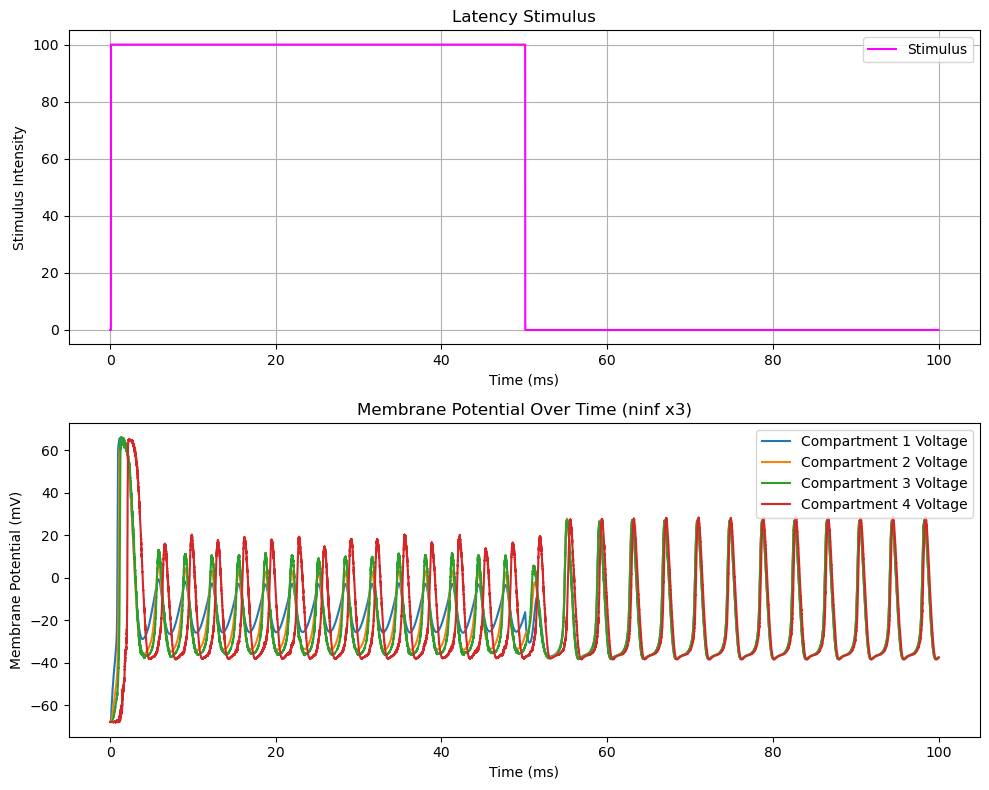

Total run time: 0:01:43.178911


In [108]:
### Plotting the results



print("Plotting graph...")
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(time, stimulus, color='magenta', label='Stimulus')
ax[0].set_title(f'{stimulus_mode.capitalize()} Stimulus')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Stimulus Intensity')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(time, v[0, :], label='Compartment 1 Voltage')
ax[1].plot(time, v[1, :], label='Compartment 2 Voltage')
ax[1].plot(time, v[2, :], label='Compartment 3 Voltage')
ax[1].plot(time, v[3, :], label='Compartment 4 Voltage')
ax[1].set_title('Membrane Potential Over Time (ninf x3)')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Membrane Potential (mV)')
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

end_time = datetime.now()
duration = end_time - start_time
print(f"Total run time: {duration}")

Plotting graph...


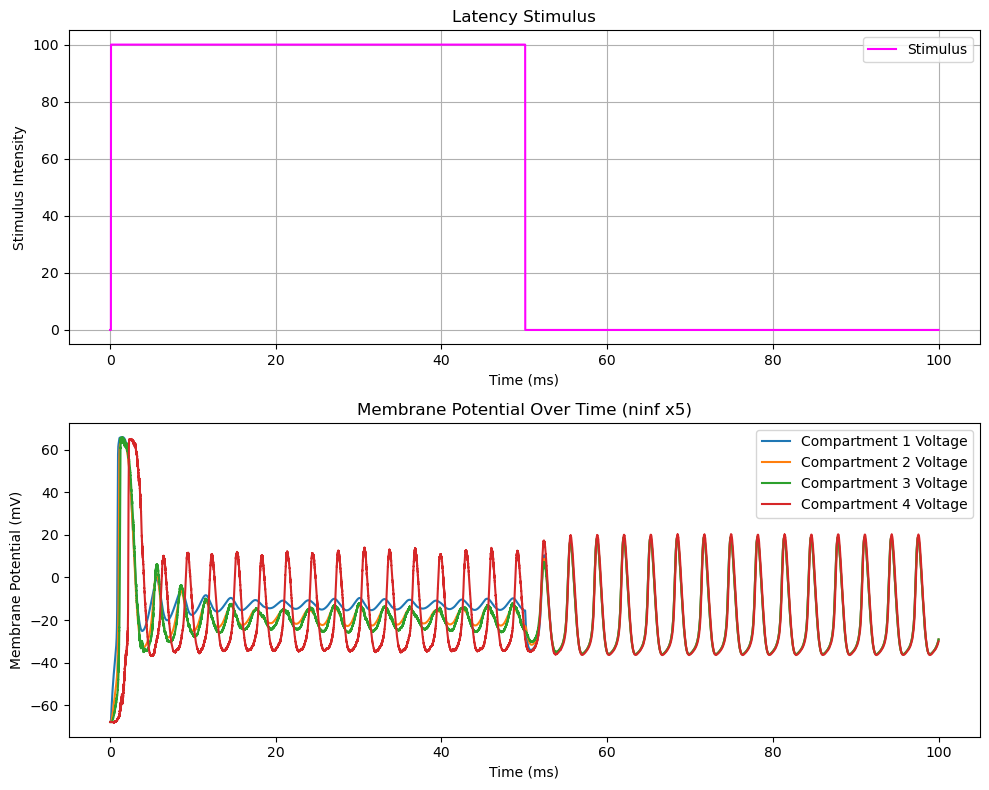

Total run time: 0:01:02.817042


In [110]:
### Plotting the results



print("Plotting graph...")


fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(time, stimulus, color='magenta', label='Stimulus')
ax[0].set_title(f'{stimulus_mode.capitalize()} Stimulus')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Stimulus Intensity')
ax[0].grid(True)
ax[0].legend()
ax[1].plot(time, v[0, :], label='Compartment 1 Voltage')
ax[1].plot(time, v[1, :], label='Compartment 2 Voltage')
ax[1].plot(time, v[2, :], label='Compartment 3 Voltage')
ax[1].plot(time, v[3, :], label='Compartment 4 Voltage')
ax[1].set_title('Membrane Potential Over Time (ninf x5)')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Membrane Potential (mV)')
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

end_time = datetime.now()
duration = end_time - start_time
print(f"Total run time: {duration}")

Plotting graph...


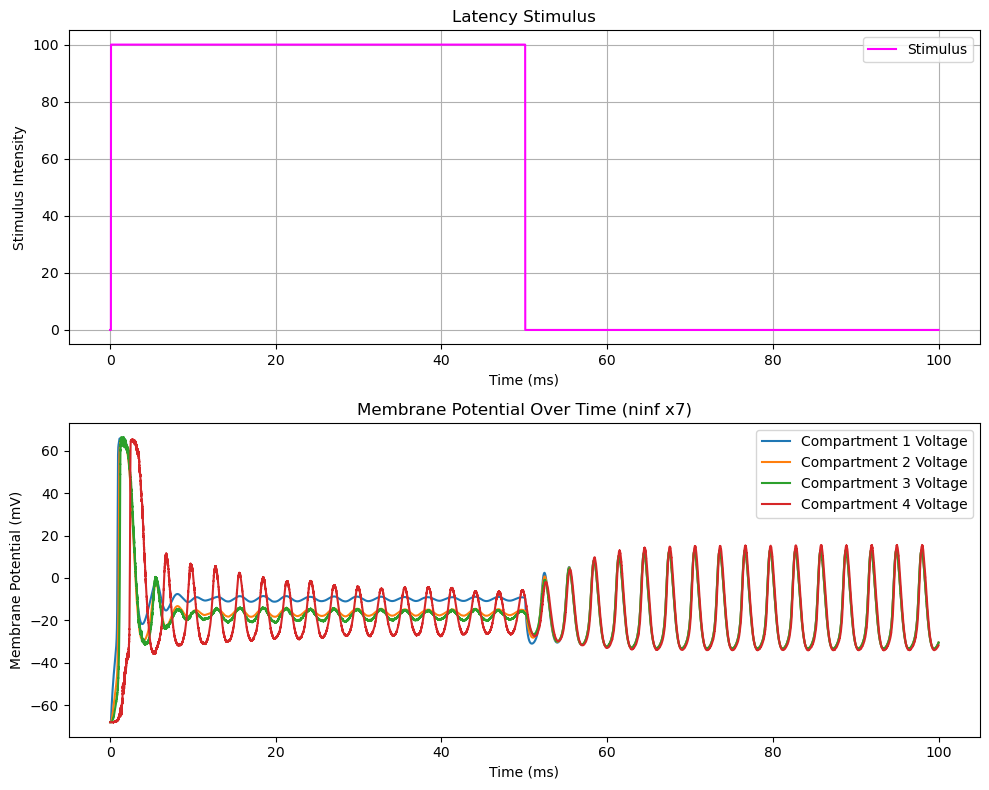

Total run time: 0:00:59.954888


In [112]:
### Plotting the results



print("Plotting graph...")

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(time, stimulus, color='magenta', label='Stimulus')
ax[0].set_title(f'{stimulus_mode.capitalize()} Stimulus')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Stimulus Intensity')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(time, v[0, :], label='Compartment 1 Voltage')
ax[1].plot(time, v[1, :], label='Compartment 2 Voltage')
ax[1].plot(time, v[2, :], label='Compartment 3 Voltage')
ax[1].plot(time, v[3, :], label='Compartment 4 Voltage')
ax[1].set_title('Membrane Potential Over Time (ninf x7)')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Membrane Potential (mV)')
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

end_time = datetime.now()
duration = end_time - start_time
print(f"Total run time: {duration}")

# ChR2 in all compartments

Plotting graph...


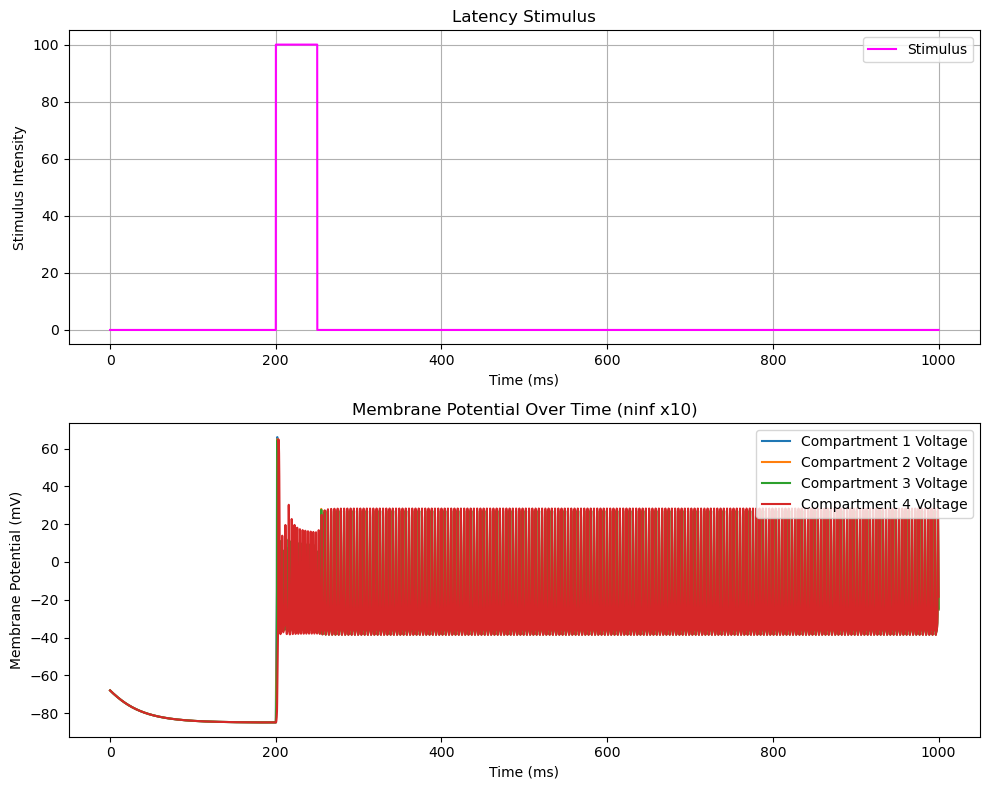

Total run time: 0:07:31.532706


# ChR2 in compartments 1-3

Plotting graph...


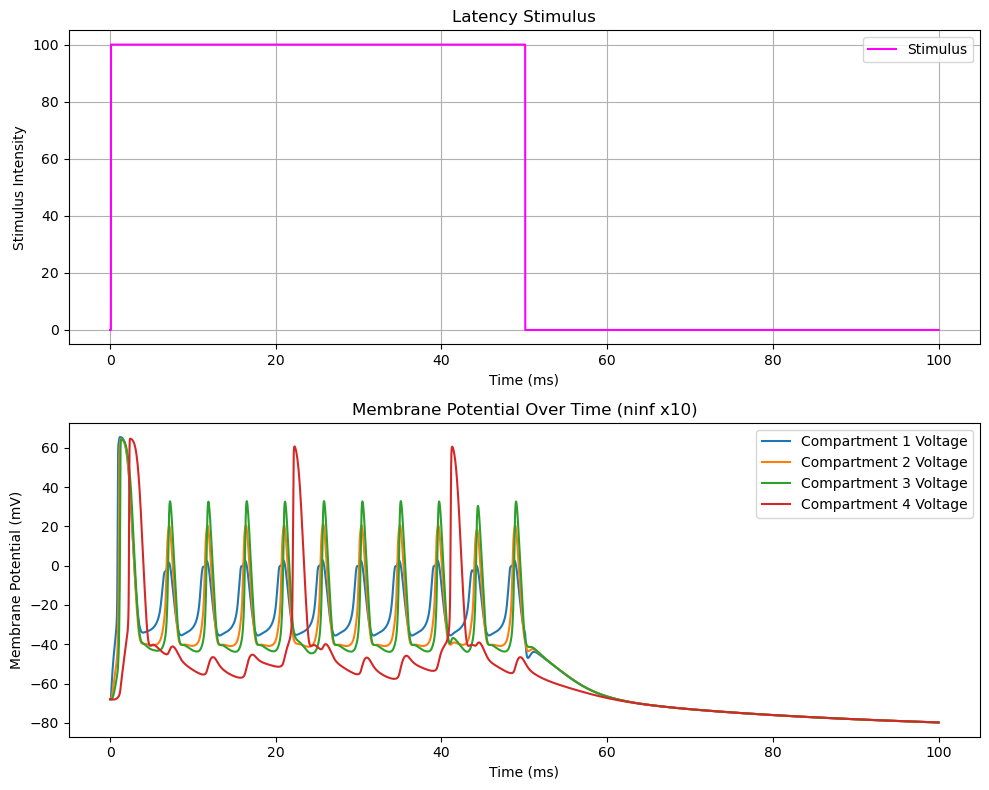

Total run time: 0:00:46.448240
